В цьому домашньому завданні ми проведемо додаткові експерименти для рішення задачі бінарної класифікації і створимо ваш новий submission на змагання на Kaggle.

-----------


**Завдання 0**. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0). Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").

**Завдання 1**. **Збираємо весь код з попереднього ДЗ в одному місці.** В лекційному ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb` ми познайомились з поняттям пайплайнів, а також я показала, як компактно виглядає рішення МЛ задачі, якщо ми зберемо весь код разом.

Оскільки ми далі будемо робити експерименти, які включають ті самі етапи попередньої обробки, але інше моделювання - буде зручно мати весь код компактно і під рукою. Тому зараз ми займемось збором коду до купи :) Після цього завдання для подальших експериментів ви можете перенести частини розвʼязку взагалі в окремий `.py` файл, аби було зручно імпортувати функції.

Зі свого рішення в попередньому домашньому завданні (`Логістична регресія з scikit learn.ipynb`) зберіть усі кроки розвʼязку задачі разом з використанням `sklearn.Pipeline` за прикладом з лекції.

Ваш код нижче має містити
1. Читання даних з файлу (поза пайплайном).
2. Розбиття на тренувальний і валідаційний набори, де валідаційний містить 20% даних (поза пайплайном).
3. Виділення категоріальних і числових колонок (поза пайплайном).
4. Підготовку категоріальних і числових колонок (частина пайплайну). В прикладі в лекції ми оформлювали обробку числових і категоріальних колонок в окремі трансформери `numeric_transformer`, `categorical_cols`. Рекоемндую зробити саме так, так потім зручніше вносити зміни :)
5. Тренування лог регресії (частина пайплайну).
6. Запуск пайплайну на тренування на трен. даних (поза пайплайном).
7. Запуск пайплайну на передбачення на трен і вал. даних і вимір метрик якості ROC-AUC + вивдення Confusion Matrix (поза пайплайном).
8. Збереження моделі в формат joblib (поза пайплайном).

Ви це все вже зробили в попереднтьому ДЗ! Тож, тут просто заадча все зібрати разом.

Нижче я додала підказки, що покроково ви маєте зробити. Якщо ви почуваєтесь впевнено, можете видалити ці підказки і реалізувати все самостійно, або ж - просто заповнити пропуски.

Завдання оцінюється в 10 балів. Головний результат - аби код в фіналі був робочий. Бо за не робочий нам гроші ніхто не заплатить :)

In [1]:
!pip install opendatasets --upgrade --quiet

In [2]:
import opendatasets as od
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, roc_curve, auc, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [ ]:
od.download('https://www.kaggle.com/competitions/bank-customer-churn-prediction-dlu')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: andrikoks
Your Kaggle Key: ··········


100%|██████████| 637k/637k [00:00<00:00, 58.2MB/s]


Extracting archive ./bank-customer-churn-prediction-dlu/bank-customer-churn-prediction-dlu.zip to ./bank-customer-churn-prediction-dlu


In [ ]:
cd bank-customer-churn-prediction-dlu/

/content/bank-customer-churn-prediction-dlu


In [ ]:
ls

sample_submission.csv  test.csv  train.csv


Area under ROC score on Train dataset: 0.9022%


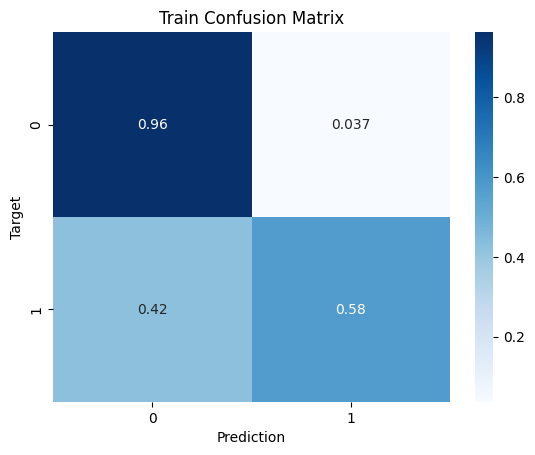

Area under ROC score on Validation dataset: 0.8844%


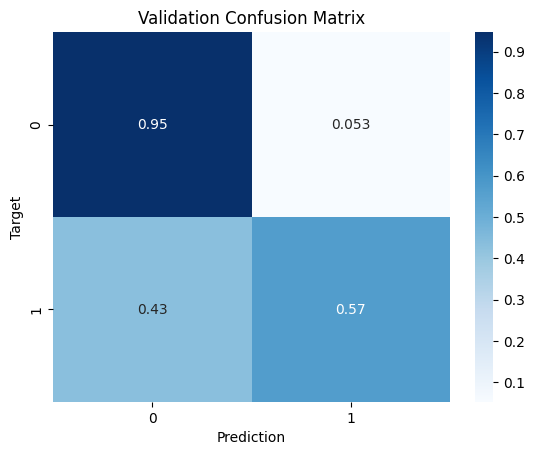

['log_reg_pieline.joblib']

In [ ]:
raw_df = pd.read_csv('train.csv')
target = raw_df['Exited']
train_df, val_df = train_test_split(raw_df, test_size=0.2, random_state=42, stratify=target)

# Створюємо трен. і вал. набори
input_cols = list(raw_df.columns)[1:-1]
target_col = 'Exited'
train_inputs, train_targets = train_df[input_cols].copy(), train_df[target_col].copy()
val_inputs, val_targets = val_df[input_cols].copy(), val_df[target_col].copy()

#видаляю колонки 'CustomerID', 'Surname'
#train_inputs.drop(columns=['CustomerId', 'Surname'], inplace=True, axis=1)
#val_inputs.drop(columns=['CustomerId', 'Surname'], inplace=True, axis=1)

# Виявляємо числові і категоріальні колонки
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()

# Створюємо трансформери для числових і категоріальних колонок
numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

# Комбінуємо трансформери для різних типів колонок в один препроцесор
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Стоврюємо пайплайн, який спочатку запускає препроцесинг, потім тренуєм модель
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear'))
])

# Тренуємо пайплайн
model_pipeline.fit(train_inputs, train_targets)

# Функція, щоб передбачати і рахувати метрики
def predict_and_plot(inputs, targets, name=''):
    preds = model_pipeline.predict(inputs)
    pred_proba = model_pipeline.predict_proba(inputs)[:, 1]
    fpr, tpr, thresholds = roc_curve(targets, pred_proba, pos_label=1.0)
    roc_auc = auc(fpr, tpr)
    print(f"Area under ROC score on {name} dataset: {roc_auc:.4f}%")
    cf = confusion_matrix(targets, preds, normalize='true')
    plt.figure()
    sns.heatmap(cf, annot=True, cmap='Blues')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name))
    plt.show()
    return preds

# Оцінюємо модель на трен і вал даних
train_preds = predict_and_plot(train_inputs, train_targets, 'Train')
val_preds = predict_and_plot(val_inputs, val_targets, 'Validation')

# Зберігаємо модель для подальшого використання
joblib.dump(model_pipeline, 'log_reg_pieline.joblib')


**Завдання 2**. Такс, у нас з вами є вже готовий пайплайн. Давайте проведемо нові експерименти.

  Додайте в попередню обробку числових колонок генерацію polinomal features до степені 2 включно. Для цього створіть новий препроцесор і створіть новий пайплайн.

  Запустіть пайплайн на тренування і виведіть метрики для тренувального і валідаційного набору. Напишіть, як вам модель? Чи спостерігається в цій моделі overfit чи underfit? Чи ця модель добре генералізує?

Area under ROC score on Train dataset: 0.9278%


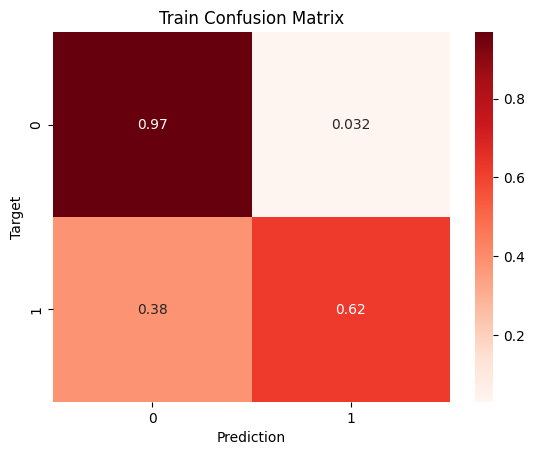

Area under ROC score on Validation dataset: 0.9149%


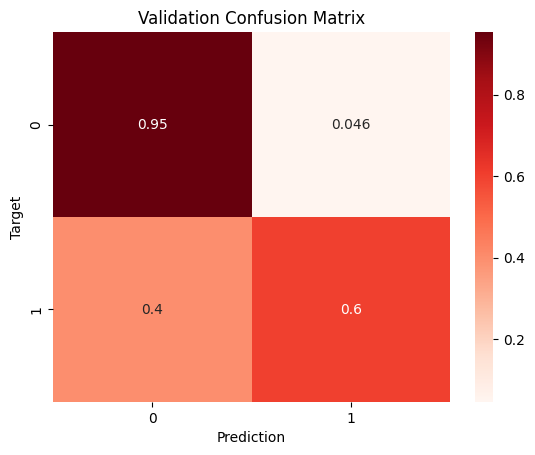

['log_reg_pieline_pfx2.joblib']

In [ ]:
numeric_transformer_pf2 = Pipeline(steps=[
     ('polynomial_features', PolynomialFeatures(degree=2, include_bias=False)),
     ('scaler', MinMaxScaler())
])

# Комбінуємо трансформери для різних типів колонок в один препроцесор
preprocessor_pf_2 = ColumnTransformer(
    transformers=[
        #('polynomial_features', polynomial_features),
        ('num', numeric_transformer_pf2, numeric_cols),
        ('cat', categorical_transformer, categorical_cols),
        #('polynomial_features', polynomial_features)
    ])

# Стоврюємо пайплайн, який спочатку запускає препроцесинг, потім тренуєм модель
model_pipeline_pf_2 = Pipeline(steps=[
    ('preprocessor_pf', preprocessor_pf_2),
    ('classifier', LogisticRegression(solver='liblinear'))
])


# Тренуємо пайплайн
model_pipeline_pf_2.fit(train_inputs, train_targets)

# Функція, щоб передбачати і рахувати метрики
def predict_poly2_reg_and_plot(inputs, targets, name=''):
    preds = model_pipeline_pf_2.predict(inputs)
    pred_proba = model_pipeline_pf_2.predict_proba(inputs)[:, 1]
    fpr, tpr, thresholds = roc_curve(targets, pred_proba, pos_label=1.0)
    roc_auc = auc(fpr, tpr)
    print(f"Area under ROC score on {name} dataset: {roc_auc:.4f}%")
    cf = confusion_matrix(targets, preds, normalize='true')
    plt.figure()
    sns.heatmap(cf, annot=True, cmap='Reds')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name))
    plt.show()
    return preds

# Оцінюємо модель на трен і вал даних
train_preds_pf = predict_poly2_reg_and_plot(train_inputs, train_targets, 'Train')
val_preds_pf = predict_poly2_reg_and_plot(val_inputs, val_targets, 'Validation')

# Зберігаємо модель для подальшого використання
joblib.dump(model_pipeline_pf_2, 'log_reg_pieline_pfx2.joblib')


Схоже, що модель із поліноміальними ознаками 2-го степеня будує кразу моделт

**Завдання 3**. Тепер давайте створимо ще новий пайплайн, тільки тепер поліноміальні ознаки згенеруємо до степені 4. Зробіть висновок про якість моделі. Якщо вам подобається резульат якоїсь з моделей в цьому ДЗ - рекомендую зробити submission в змаганні.

Area under ROC score on Train dataset: 0.9447%


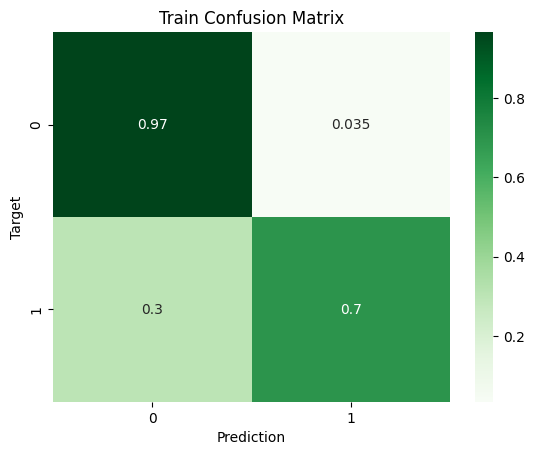

Area under ROC score on Validation dataset: 0.9322%


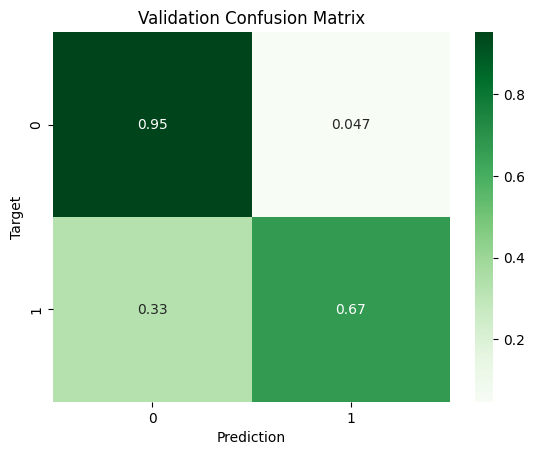

['log_reg_pieline_pfx4.joblib']

In [ ]:
numeric_transformer_pf4 = Pipeline(steps=[
     ('polynomial_features', PolynomialFeatures(degree=4, include_bias=False)),
     ('scaler', MinMaxScaler())
])

# Комбінуємо трансформери для різних типів колонок в один препроцесор
preprocessor_pf_4 = ColumnTransformer(
    transformers=[
        #('polynomial_features', polynomial_features),
        ('num', numeric_transformer_pf4, numeric_cols),
        ('cat', categorical_transformer, categorical_cols),
        #('polynomial_features', polynomial_features)
    ])

# Стоврюємо пайплайн, який спочатку запускає препроцесинг, потім тренуєм модель
model_pipeline_pf_4 = Pipeline(steps=[
    ('preprocessor_pf', preprocessor_pf_4),
    ('classifier', LogisticRegression(solver='liblinear'))
])


# Тренуємо пайплайн
model_pipeline_pf_4.fit(train_inputs, train_targets)

# Функція, щоб передбачати і рахувати метрики
def predict_poly4_reg_and_plot(inputs, targets, name=''):
    preds = model_pipeline_pf_4.predict(inputs)
    pred_proba = model_pipeline_pf_4.predict_proba(inputs)[:, 1]
    fpr, tpr, thresholds = roc_curve(targets, pred_proba, pos_label=1.0)
    roc_auc = auc(fpr, tpr)
    print(f"Area under ROC score on {name} dataset: {roc_auc:.4f}%")
    cf = confusion_matrix(targets, preds, normalize='true')
    plt.figure()
    sns.heatmap(cf, annot=True, cmap='Greens')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name))
    plt.show()
    return preds

# Оцінюємо модель на трен і вал даних
train_preds_pf = predict_poly4_reg_and_plot(train_inputs, train_targets, 'Train')
val_preds_pf = predict_poly4_reg_and_plot(val_inputs, val_targets, 'Validation')

# Зберігаємо модель для подальшого використання
joblib.dump(model_pipeline_pf_4, 'log_reg_pieline_pfx4.joblib')


In [ ]:
input_cols_t = list(raw_df.columns)[:-1]

In [ ]:
test_df = pd.read_csv('test.csv')

In [ ]:
test_inputs = test_df[input_cols_t].copy()

In [ ]:
test_inputs.head(1)

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,15000,15594796.0,Chu,584.0,Germany,Male,30.0,2.0,146053.66,1.0,1.0,1.0,157891.86


In [ ]:
test_inputs.shape

(10000, 13)

In [ ]:
test_pred_prob_pf_2 = model_pipeline_pf_2.predict_proba(test_inputs)[:, 1]

In [ ]:
test_pred_prob_pf_2.shape

(10000,)

In [ ]:
test_inputs['Exited'] = test_pred_prob_pf_2

In [ ]:
submission = pd.read_csv('sample_submission.csv')

In [ ]:
submission.set_index('id', inplace=True)
test_inputs.set_index('id', inplace=True)

In [ ]:
submission.update(test_inputs[['Exited']])

submission.reset_index(inplace=True)
test_inputs.reset_index(inplace=True)


submission[:2]

,id,Exited
0,15000,0.032289
1,15001,0.044261


In [ ]:
submission.to_csv('submission_log_reg_pf_2.csv', index=False)

In [ ]:
test_pred_prob_pf_4 = model_pipeline_pf_4.predict_proba(test_inputs)[:, 1]

In [ ]:
test_inputs_4 = test_df[input_cols_t].copy()

In [ ]:
test_inputs_4['Exited'] = test_pred_prob_pf_4

In [ ]:
submission_4 = pd.read_csv('sample_submission.csv')

In [ ]:
submission_4.set_index('id', inplace=True)
test_inputs_4.set_index('id', inplace=True)

In [ ]:
submission_4.update(test_inputs_4[['Exited']])

submission_4.reset_index(inplace=True)
test_inputs_4.reset_index(inplace=True)
submission[:2]

,id,Exited
0,15000,0.032289
1,15001,0.044261


In [ ]:
submission_4.to_csv('submission_log_reg_pf_4.csv', index=False)

**Завдання 4. Перенавчання і регуляризація**.

  Скачайте набір даних `regression_data.csv`. Звичайте набір даних з `regression_data.csv`, розбийте на train і test (в тест 20%) і натренуйте модель лінійної регресії з масштабуванням числових ознак і поліноміальними ознаками до степені **5 включно**.

  Виміряйте якість прогностичної моделі і зробіть висновок, чи модель хороша, чи вона добре генералізує?


In [3]:
lin_reg = pd.read_csv('regression_data.csv')

In [ ]:
lin_reg.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,target
0,-0.190339,-1.382800,-0.875618,0.538910,-1.037246,28.938854
1,-0.321386,-0.563725,0.412931,-0.147057,-0.825497,-7.664581
2,2.122156,-1.519370,1.032465,-1.260884,0.917862,-63.845482
3,-1.380101,-0.055548,-1.703382,0.074095,1.628616,4.076259
4,-0.072829,-1.514847,-0.846794,0.714000,0.473238,34.879013


In [22]:
target_lin = lin_reg['target']
train_lin, test_lin = train_test_split(lin_reg, test_size=0.2, random_state=42)

# Створюємо трен. і вал. набори
input_cols_lin = list(lin_reg.columns)[:-1]
target_col_lin = 'target'
train_inputs_lin, train_targets_lin = train_lin[input_cols_lin].copy(), train_lin[target_col_lin].copy()
test_inputs_lin, test_targets_lin = test_lin[input_cols_lin].copy(), test_lin[target_col_lin].copy()

In [5]:
def train_lin_poly_reg(x_train, y_train, x_test, y_test, degree):
  poly_features = PolynomialFeatures(degree=degree)
  scaler = MinMaxScaler()
  lin_poly_reg = LinearRegression()

  x_train_poly = poly_features.fit_transform(x_train)
  x_test_poly = poly_features.transform(x_test)

  scaler.fit_transform(x_train_poly)
  scaler.transform(x_test_poly)

  lin_poly_reg.fit(x_train_poly, y_train)
  y_predict_train_lin_poly = lin_poly_reg.predict(x_train_poly)
  y_predict_test_lin_poly = lin_poly_reg.predict(x_test_poly)

  rmse_train_lin_poly = mean_squared_error(y_train, y_predict_train_lin_poly, squared=False)
  rmse_test_lin_poly = mean_squared_error(y_test, y_predict_test_lin_poly, squared=False)

  print(f"Train RMSE for Polynomial Regression (degree {degree}): {np.sqrt(rmse_train_lin_poly):.3f}")
  print(f"Test RMSE for Polynomial Regression (degree {degree}): {np.sqrt(rmse_test_lin_poly):.3f}\n")

In [6]:
degree = 1
train_lin_poly_reg(train_inputs_lin, train_targets_lin, test_inputs_lin, test_targets_lin, degree)

Train RMSE for Polynomial Regression (degree 1): 1.033
Test RMSE for Polynomial Regression (degree 1): 0.940



In [7]:
degree = 2
train_lin_poly_reg(train_inputs_lin, train_targets_lin, test_inputs_lin, test_targets_lin, degree)

Train RMSE for Polynomial Regression (degree 2): 1.008
Test RMSE for Polynomial Regression (degree 2): 1.007



In [8]:
degree = 3
train_lin_poly_reg(train_inputs_lin, train_targets_lin, test_inputs_lin, test_targets_lin, degree)

Train RMSE for Polynomial Regression (degree 3): 0.894
Test RMSE for Polynomial Regression (degree 3): 1.384



In [9]:
degree = 4
train_lin_poly_reg(train_inputs_lin, train_targets_lin, test_inputs_lin, test_targets_lin, degree)

Train RMSE for Polynomial Regression (degree 4): 0.000
Test RMSE for Polynomial Regression (degree 4): 4.390



In [10]:
degree = 5
train_lin_poly_reg(train_inputs_lin, train_targets_lin, test_inputs_lin, test_targets_lin, degree)

Train RMSE for Polynomial Regression (degree 5): 0.000
Test RMSE for Polynomial Regression (degree 5): 5.425



In [11]:
np.mean(train_targets_lin), np.std(train_targets_lin), np.min(train_targets_lin), np.max(train_targets_lin)

(-6.450753928428644,
 44.13422004765027,
 -111.75381023526477,
 109.45509141612668)

In [12]:
np.mean(test_targets_lin), np.std(test_targets_lin), np.min(test_targets_lin), np.max(test_targets_lin)

(6.190106769386836, 48.30181674637871, -84.2273771262452, 115.12590740098972)

Результати, на мою думку, вийшли дуже хороші, на степені 4 і 5 на тестових даних модель вже практично не помиляється на тренувальних даних. Проте на 4 і 5 степені збільшується помилка на тестових даних, хоч вона все одно допустима, враховуючи середнє значення та стандартне відхилення по таргетах на тесті.

Для даного датасету я би зупинився на 3-му степені.

**Завдання 5**. Натренуйте моделі Lasso(), Ridge(), ElasaticNet() на цих даних (з поліном ознаками до степені 20 включно), порівняйте якість з тою, яка була отримана з лог регресією. Яка модель найкраще генералізує і чому на ваш погляд (можливо треба буде для відповіді зробити додатковий аналіз ознак)?

In [13]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
models = [
    Ridge(),
    Ridge(alpha=2),
    Lasso(),
    ElasticNet(),
    ElasticNet(alpha=0.5)
]

In [37]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_metrics = mean_squared_error(y_train, y_train_pred, squared=False).round(6)
    test_metrics = mean_squared_error(y_test, y_test_pred, squared=False).round(6)

    return dict(train=train_metrics, test=test_metrics)

In [47]:
for model in models:
    poly_features = PolynomialFeatures(degree=1)
    x_train_poly = poly_features.fit_transform(train_inputs_lin)
    x_test_poly = poly_features.transform(test_inputs_lin)
    model.fit(x_train_poly, train_targets_lin)
    eval_results  = evaluate_model(model, x_train_poly, train_targets_lin, x_test_poly, test_targets_lin)
    print(f'{str(model)}: {eval_results}\n')

Ridge(): {'train': 1.197553, 'test': 0.992599}

Ridge(alpha=2): {'train': 1.515007, 'test': 1.380979}

Lasso(): {'train': 1.571223, 'test': 1.512621}

ElasticNet(): {'train': 17.578714, 'test': 19.681644}

ElasticNet(alpha=0.5): {'train': 10.963928, 'test': 12.192434}



In [48]:
for model in models:
    poly_features = PolynomialFeatures(degree=1)
    x_train_poly = poly_features.fit_transform(train_inputs_lin)
    x_test_poly = poly_features.transform(test_inputs_lin)
    scaler = MinMaxScaler()
    scaler.fit_transform(x_train_poly)
    scaler.transform(x_test_poly)
    model.fit(x_train_poly, train_targets_lin)
    eval_results  = evaluate_model(model, x_train_poly, train_targets_lin, x_test_poly, test_targets_lin)
    print(f'{str(model)}: {eval_results}\n')
    scaler = MinMaxScaler()
    scaler.fit_transform(x_train_poly)
    scaler.transform(x_test_poly)

Ridge(): {'train': 1.197553, 'test': 0.992599}

Ridge(alpha=2): {'train': 1.515007, 'test': 1.380979}

Lasso(): {'train': 1.571223, 'test': 1.512621}

ElasticNet(): {'train': 17.578714, 'test': 19.681644}

ElasticNet(alpha=0.5): {'train': 10.963928, 'test': 12.192434}



In [39]:
for model in models:
    poly_features = PolynomialFeatures(degree=2)
    x_train_poly = poly_features.fit_transform(train_inputs_lin)
    x_test_poly = poly_features.transform(test_inputs_lin)
    model.fit(x_train_poly, train_targets_lin)
    eval_results  = evaluate_model(model, x_train_poly, train_targets_lin, x_test_poly, test_targets_lin)
    print(f'{str(model)}: {eval_results}\n')

Ridge(): {'train': 1.170678, 'test': 1.2341}

Ridge(alpha=2): {'train': 1.529127, 'test': 1.725789}

Lasso(): {'train': 1.571223, 'test': 1.512621}

ElasticNet(): {'train': 17.394886, 'test': 20.761708}

ElasticNet(alpha=0.5): {'train': 10.984113, 'test': 13.211056}



In [49]:
for model in models:
    poly_features = PolynomialFeatures(degree=2)
    x_train_poly = poly_features.fit_transform(train_inputs_lin)
    x_test_poly = poly_features.transform(test_inputs_lin)
    scaler = MinMaxScaler()
    scaler.fit_transform(x_train_poly)
    scaler.transform(x_test_poly)
    model.fit(x_train_poly, train_targets_lin)
    eval_results  = evaluate_model(model, x_train_poly, train_targets_lin, x_test_poly, test_targets_lin)
    print(f'{str(model)}: {eval_results}\n')
    scaler = MinMaxScaler()
    scaler.fit_transform(x_train_poly)
    scaler.transform(x_test_poly)

Ridge(): {'train': 1.170678, 'test': 1.2341}

Ridge(alpha=2): {'train': 1.529127, 'test': 1.725789}

Lasso(): {'train': 1.571223, 'test': 1.512621}

ElasticNet(): {'train': 17.394886, 'test': 20.761708}

ElasticNet(alpha=0.5): {'train': 10.984113, 'test': 13.211056}



In [40]:
for model in models:
    poly_features = PolynomialFeatures(degree=3)
    x_train_poly = poly_features.fit_transform(train_inputs_lin)
    x_test_poly = poly_features.transform(test_inputs_lin)
    model.fit(x_train_poly, train_targets_lin)
    eval_results  = evaluate_model(model, x_train_poly, train_targets_lin, x_test_poly, test_targets_lin)
    print(f'{str(model)}: {eval_results}\n')

Ridge(): {'train': 1.80872, 'test': 7.881783}

Ridge(alpha=2): {'train': 2.820853, 'test': 11.685399}

Lasso(): {'train': 1.869197, 'test': 1.936133}

ElasticNet(): {'train': 12.414655, 'test': 19.290081}

ElasticNet(alpha=0.5): {'train': 9.906089, 'test': 20.435729}



In [41]:
import warnings

warnings.filterwarnings("ignore")

for model in models:
    poly_features = PolynomialFeatures(degree=5)
    x_train_poly = poly_features.fit_transform(train_inputs_lin)
    x_test_poly = poly_features.transform(test_inputs_lin)
    model.fit(x_train_poly, train_targets_lin)
    eval_results  = evaluate_model(model, x_train_poly, train_targets_lin, x_test_poly, test_targets_lin)
    print(f'{str(model)}: {eval_results}\n')

Ridge(): {'train': 1.258071, 'test': 29.489894}

Ridge(alpha=2): {'train': 1.982396, 'test': 30.5266}

Lasso(): {'train': 1.947741, 'test': 2.366125}

ElasticNet(): {'train': 11.66084, 'test': 43.160849}

ElasticNet(alpha=0.5): {'train': 8.588997, 'test': 34.955145}



In [42]:
import warnings

warnings.filterwarnings("ignore")

for model in models:
    poly_features = PolynomialFeatures(degree=10)
    x_train_poly = poly_features.fit_transform(train_inputs_lin)
    x_test_poly = poly_features.transform(test_inputs_lin)
    model.fit(x_train_poly, train_targets_lin)
    eval_results  = evaluate_model(model, x_train_poly, train_targets_lin, x_test_poly, test_targets_lin)
    print(f'{str(model)}: {eval_results}\n')

Ridge(): {'train': 1.257238, 'test': 995.721849}

Ridge(alpha=2): {'train': 1.881348, 'test': 1056.45768}

Lasso(): {'train': 2.187687, 'test': 26.874356}

ElasticNet(): {'train': 10.238539, 'test': 143.834046}

ElasticNet(alpha=0.5): {'train': 7.815447, 'test': 142.771899}



In [43]:
import warnings

warnings.filterwarnings("ignore")

for model in models:
    poly_features = PolynomialFeatures(degree=15)
    x_train_poly = poly_features.fit_transform(train_inputs_lin)
    x_test_poly = poly_features.transform(test_inputs_lin)
    model.fit(x_train_poly, train_targets_lin)
    eval_results  = evaluate_model(model, x_train_poly, train_targets_lin, x_test_poly, test_targets_lin)
    print(f'{str(model)}: {eval_results}\n')

Ridge(): {'train': 1.356414, 'test': 23409.885013}

Ridge(alpha=2): {'train': 1.919863, 'test': 18122.603327}

Lasso(): {'train': 2.299612, 'test': 69.9744}

ElasticNet(): {'train': 10.15162, 'test': 452.846094}

ElasticNet(alpha=0.5): {'train': 7.741371, 'test': 583.24298}



In [44]:
import warnings

warnings.filterwarnings("ignore")

for model in models:
    poly_features = PolynomialFeatures(degree=20)
    x_train_poly = poly_features.fit_transform(train_inputs_lin)
    x_test_poly = poly_features.transform(test_inputs_lin)
    model.fit(x_train_poly, train_targets_lin)
    eval_results  = evaluate_model(model, x_train_poly, train_targets_lin, x_test_poly, test_targets_lin)
    print(f'{str(model)}: {eval_results}\n')

Ridge(): {'train': 32.581837, 'test': 9048.133334}

Ridge(alpha=2): {'train': 32.581837, 'test': 9048.133334}

Lasso(): {'train': 2.313505, 'test': 68.318791}

ElasticNet(): {'train': 10.159852, 'test': 1526.820921}

ElasticNet(alpha=0.5): {'train': 7.741732, 'test': 1083.402468}



З поліноміальними ознаками 10-20 степеня вже ніяка модель не справляється, ознак забагато. Лінійна регресія справилась краще.
В степенях 1-5 Lasso дає не погані результати.
